In [1]:
import numpy as np 
import pandas as pd 
import pydicom
import nibabel as nib 
import dicom2nifti
import matplotlib.pyplot as plt
import os
import cv2
import shutil

In [2]:
import pandas as pd
test_df = pd.DataFrame()
test_df['Id'] = ['20230213002651']
test_df['sequence'] = ['801001_t1w_ir_c_fs.nii.gz']
test_df.to_csv('../test_data.tsv', sep='\t', index=False, float_format='%.0f')

In [ ]:
import pandas as pd 
ori_file = '../final_data_infos_new_cls.xlsx'
ori_data = pd.read_excel(ori_file, converters={"检查流水号": str})
ori_data.rename(columns={'检查流水号':"Id", '姓名':'Name','性别':"Gender",'年龄':'Age','组织学分型':'class_Des','组织学分型(经典型=1，促纤维结合增生型=2，大细胞间变型=3，广泛结节型=4，NOS=5)':'Classification','组织学分型(经典型=1，其他=2)':"Classification_v2"}, inplace=True)
print(ori_data.head(5))
ori_data.to_excel('../all_data_infos_new_class.xlsx', index=False, float_format='%.0f')

In [9]:
# 用新分类数据和原始数据进行merge，重新划分数据集
import pandas as pd 
ori_cls_file = '../all_data_infos_new_class_selected_sequence_5fold.xlsx'
new_cls_file = '../final_data_infos_1017_another_cls.xlsx'
ori_df = pd.read_excel(ori_cls_file, converters={'patient_name': str})
ori_df = ori_df[['Id', 'Name', 'Gender', 'Age', 'class_Des', 'Classification', 'Classification_v2', 'sequence']]
new_cls_df = pd.read_excel(new_cls_file, converters={'patient_name': str})
print(len(new_cls_df))
new_cls_df.dropna(axis=0, subset=['分子lable'], inplace=True)
print(len(new_cls_df))
new_cls_df.rename(columns={'检查流水号': 'Id', '分子lable': 'Classification_v3'}, inplace=True)
new_cls_df = new_cls_df[['Id', 'Classification_v3']]
final_df = pd.merge(new_cls_df, ori_df, on='Id', how='left')
print(len(final_df))
print(final_df.head())
final_df.to_excel('../new_all_data_infos.xlsx', index=False, float_format='%.0f')

378
193
193
               Id Classification_v3 Name Gender  Age class_Des  \
0  20161229001772                 4  唐仕俊      男    3    大细胞间变型   
1  20190919003349                 2   周依      女    9       经典型   
2  20171025001244                 4  赵芮伊      女    5    大细胞间变型   
3  20190529003221                 2  刘森阳      男   12  促纤维增生结节型   
4  20190610002778                 3  王健舟      男    2     广泛结节型   

   Classification  Classification_v2                        sequence  
0               3                  2  3_t2_tse_tra_p2_24slice.nii.gz  
1               1                  1       4_oax_t2_propeller.nii.gz  
2               3                  2      3_t2_tse_tra_320_p2.nii.gz  
3               2                  2      3_t2_tse_tra_320_p2.nii.gz  
4               4                  2  400_flcoax_t2_propeller.nii.gz  


In [12]:
# 把挑选出来的单独的序列名字和之前的分类信息表结合起来
import pandas as pd 
cls_file = '../all_data_infos_new_class_5fold.xlsx'
selected_file = '../patient_sequence_name_selected_t2.xlsx'
cls_data = pd.read_excel(cls_file, converters={'Id': str})
# print(cls_data.head(5))
selected_data = pd.read_excel(selected_file, converters={'patient_name': str}, sheet_name='T2')
# print(selected_data.head(5))
all_patients = []
all_patient_seq = []
all_columns = selected_data.columns.values
for i, row in selected_data.iterrows():
    # patient_name = selected_data.loc[i,]
    row_data = selected_data.loc[i, all_columns].values
    patient = row_data[0]
    used_sequence = [n for n in row_data[1:] if n != '0' and n!=0]
    all_patients.append(patient)
    all_patient_seq.append(used_sequence[0])

assert len(all_patients) == len(all_patient_seq)
new_selected_data = pd.DataFrame()
new_selected_data['Id'] = all_patients 
new_selected_data['sequence'] = all_patient_seq
print(new_selected_data.head(5))
new_cls_data = pd.merge(cls_data, new_selected_data, on='Id')
print(new_cls_data.head(5))
new_cls_data.to_excel('../all_data_infos_new_class_selected_sequence_5_fold.xlsx', index=False,float_format='%.0f')

               Id                    sequence
0  20210429000937   4_oax_t2_propeller.nii.gz
1  20140505001436         3_t2_tse_tra.nii.gz
2  20140320000729        4_ax_t2_frfse.nii.gz
3  20161230000611  3_t2_tse_tra_320_p2.nii.gz
4  20130814001540         3_t2_tse_tra.nii.gz
               Id Name Gender  Age class_Des  Classification  \
0  20161229001772  唐仕俊      男    3    大细胞间变型               3   
1  20091203000900  刘朝山      男   36       NOS               5   
2  20190919003349   周依      女    9       经典型               1   
3  20171025001244  赵芮伊      女    5    大细胞间变型               3   
4  20090925000383  白长申      男   38       NOS               5   

   Classification_v2  fold                        sequence  
0                  2     0  3_t2_tse_tra_p2_24slice.nii.gz  
1                  2     4             2_t2_tse_tra.nii.gz  
2                  1     1       4_oax_t2_propeller.nii.gz  
3                  2     3      3_t2_tse_tra_320_p2.nii.gz  
4                  2     1        

In [2]:
# dicom转换成nii格式的转换代码
def dicom_to_nii(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    patient_names = os.listdir(input_dir)
    for patient_name in patient_names:
        if patient_name.endswith("_nii"): continue
        if patient_name == ".DS_Store": continue
        # patient_name = patient_name.replace(" ", "_")
        data_folders = os.listdir(os.path.join(input_dir, patient_name))
        # print(data_folders)
        for data_channel_name in data_folders:
            if len(data_channel_name.split('.')) == 2: continue
            nii_folder = os.path.join(output_dir, patient_name.replace(" ", "_"))
            # print(nii_folder)
            if not os.path.exists(nii_folder):
                os.mkdir(nii_folder)
            dicom_data_folder = os.path.join(input_dir, patient_name, data_channel_name)
            # if not os.path.exists(nii_folder):
            #     os.mkdir(nii_folder)
            dicom2nifti.convert_directory(dicom_data_folder, nii_folder, compression=True, reorient=True)
        print("convert patient - {} done!".format(patient_name))

In [7]:
# 对转换成功的nii数据进行记录，记录每个病人对应的nii数据，方便后期筛选实际训练所需要使用的
def get_patient_sequence_name(input_dir):
    patient_names = os.listdir(input_dir)
    # all_patients = []
    all_patient_seqence_names = []
    all_patients = []
    all_patient_seg_label = []
    max_seq_len = 0
    for patient in patient_names:
        # all_patients.append(patient)
        patient_sequence = []
        if patient.endswith("_nii"): continue
        if patient == '.DS_Store': continue
        sequence_names = os.listdir(os.path.join(input_dir, patient))
        new_sequence_names = [x for x in sequence_names if x!='pred.nii.gz' and x!='.DS_Store']
        if len(new_sequence_names) != 3: 
            print(patient)
            continue
        # max_seq_len = max(max_seq_len, len(sequence_names))
        all_patients.append(patient)
        for sequence_name in new_sequence_names:
            if sequence_name.startswith('seg'):
                all_patient_seg_label.append(sequence_name)
            else:
                patient_sequence.append(sequence_name)

        all_patient_seqence_names.append(patient_sequence)
    
    assert len(all_patients) == len(all_patient_seqence_names)

    # 对数据进行补齐操作
    # paded_patient_sequence_names = []
    # for seqence_names in all_patient_seqence_names:
    #     if len(seqence_names) != max_seq_len:
    #         new_seq_names = seqence_names + ["0"]*(max_seq_len - len(seqence_names))
    #         paded_patient_sequence_names.append(new_seq_names)
    #     else:
    #         paded_patient_sequence_names.append(seqence_names)
    
    # res_file = input_dir + "_patient_sequence_name.xlsx"
    res_df = pd.DataFrame()
    res_df['patient_name'] = all_patients
    
    for i in range(3):
        res_df['sequence_{}'.format(i)] = [n[i] for n in all_patient_seqence_names]
        
    # res_df['seg_label'] = all_patient_seg_label


    res_df.to_excel('../patient_sequence_name.xlsx', index=False, float_format='%.0f')
    # res_df.to_(res_file, sep='\t', index=False)
        


In [3]:
ori_dir = '../cls_test_data'
nii_dir = '../cls_test_data_nii/'
dicom_to_nii(ori_dir, nii_dir)
# get_patient_sequence_name(nii_dir)

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/dicom2nifti/convert_dir.py", line 85, in convert_directory
    convert_dicom.dicom_array_to_nifti(dicom_input, nifti_file, reorient)
  File "/opt/conda/lib/python3.8/site-packages/dicom2nifti/convert_dicom.py", line 123, in dicom_array_to_nifti
    results = convert_philips.dicom_to_nifti(dicom_list, output_file)
  File "/opt/conda/lib/python3.8/site-packages/dicom2nifti/convert_philips.py", line 49, in dicom_to_nifti
    raise ConversionValidationError('TOO_FEW_SLICES/LOCALIZER')
dicom2nifti.exceptions.ConversionValidationError: TOO_FEW_SLICES/LOCALIZER
Slice increment not consistent through all slices
---------------------------------------------------------
[ -73.48949779 -104.7535058   -95.82690256] [0. 0. 0.]
[ -73.46265377 -106.70490465  -90.15316217] [-0.02684402  1.95139885 -5.67374039]
Instance Number: 170
---------------------------------------------------------
Traceback (most recent call last)

convert patient - 20230213002651 done!


In [ ]:
# 分析一下sequence的slice的数据
def crop_voxel(voxel):
    if voxel.sum() == 0:
        return voxel
    keep = (voxel.mean(axis=(0, 1)) > 0)
    voxel = voxel[:, :, keep]
    keep = (voxel.mean(axis=(0, 2)) > 0)
    voxel = voxel[:, keep]
    keep = (voxel.mean(axis=(1, 2)) > 0)
    voxel = voxel[keep]
    return voxel
path_name = '../data/0629_need_to_predict_resized/20220722000512'
plt.figure(figsize=(20, 20))
used_slice = 20

for i, file_name in enumerate(os.listdir(path_name)):
    if file_name == '.DS_Store': continue
    ori_data = nib.load(os.path.join(path_name, file_name))
    # print(ori_data.affine)
    data = ori_data.get_fdata()
    print('origin data shape is {}'.format(data.shape))
    # if file_name == 'pred.nii.gz':
    #     data = np.rot90(data, 4)
    # else:
    #     data = np.rot90(data)
    print('rotate data shape is {}'.format(data.shape))
    # num_slices = data.shape[2]
    # p1 = max(0, num_slices//2 - used_slice//2)
    # p2 = min(num_slices, num_slices//2 + used_slice//2)
    # data = data[:, :, p1:p2]
    # print('selected data size is {}'.format(data.shape))
    # # new_data = np.mean(data, axis=2)
    # # print('mean data shape is {}'.format(new_data.shape))
    # resize_data = cv2.resize(data[:, :, 12], (256, 256))
    # print('resized data size is {}'.format(resize_data.shape))
    plt.subplot(1, 5, i+1)
    plt.title(file_name)
    plt.imshow(data[:, :, 8], cmap='bone')
plt.show()
# print(np.eye(4))


In [ ]:
# 从所有序列中挑选出来有需要的序列，通过os.remove()把不需要的文件直接删除
nii_dir = '../data/0629_corrected'
ori_patient_names = os.listdir(nii_dir)
used_sequence_df = pd.read_csv('../data/sequence_name_used.tsv', sep='\t')
# print(len(used_sequence_df))
new_used_sequence_df = used_sequence_df[used_sequence_df['备注'] != '出组-图像有问题']
new_used_sequence_df.drop(columns=['备注'], inplace=True)

# print(len(new_used_sequence_df))
# print(new_used_sequence_df.columns.values)
# 删除数据有误的病人目录
# used_patient = new_used_sequence_df['patient_name'].values
# for patient in ori_patient_names:
#     if patient.endswith('.tsv'): continue
#     if patient not in used_patient:
#         print('delete patient---{} data'.format(patient))
#         shutil.rmtree(os.path.join(nii_dir, patient))

# 删除每个病人下面不用的数据
all_columns = new_used_sequence_df.columns.values
for i, row in new_used_sequence_df.iterrows():
    row_data = new_used_sequence_df.loc[i, all_columns].values
    patient = row_data[0]
    used_sequence = [n for n in row_data[1:] if n != '0'] + ['seg.nii.gz']
    if patient not in ori_patient_names:
        continue
    for file_name in os.listdir(os.path.join(nii_dir, patient)):
        if file_name not in used_sequence:
            print('delete not used sequence {}'.format(file_name))
            os.remove(os.path.join(nii_dir, patient, file_name))

all_sequence_name = []
for patient in ori_patient_names:
    sequences = os.listdir(os.path.join(nii_dir, patient))
    if len(sequences) != 3:
        print(patient)
    all_sequence_name.append(sequences)

assert len(all_sequence_name) == len(ori_patient_names)
new_patient_and_sequence = pd.DataFrame()
new_patient_and_sequence['patient_id'] = ori_patient_names
for i in range(3):
    new_patient_and_sequence['sequence_{}'.format(i)] = [n[i] for n in all_sequence_name]
# new_patient_and_sequence.to_csv('../data/patient_and_sequence_0614.tsv', index=False, sep='\t')




In [ ]:
# 处理文件，把文件夹中的不需要的文件删除
data_dir = '../data/0629_corrected'
patients_name = os.listdir(data_dir)
# patients_name = [x for x in patients_name]
for patient in patients_name:
    if patient == '.DS_Store': continue
    data_ = os.listdir(os.path.join(data_dir, patient))
    data_ = [x for x in data_ if x!= '.DS_Store']
    if len(data_) != 5:
        print('patient {} data has some error!!'.format(patient))
    for file_name in data_+['.DS_Store']:
        if file_name == 'pred.nii.gz':
            print('remove data from patient {}'.format(patient))
            os.remove(os.path.join(data_dir, patient, file_name))

In [ ]:
# 测试monai
from monai.networks.nets import BasicUNet, VNet, SegResNet, UNet
net = SegResNet(spatial_dims=3,
           in_channels=4,
           out_channels=1,
           dropout_prob=0.1,
           norm="BATCH")
net
# unet = UNet(spatial_dims=3,
#             in_channels=4,
#             out_channels=1,
#             channels=(16, 32, 64, 128, 256),
#             strides=(2, 2, 2, 2),
#             num_res_units=2,
#             norm="BATCH")
# unet

ori image shape is (3, 256, 256, 5)
cls image shape is (256, 256, 15)
mask image shape is (1, 256, 256, 16)


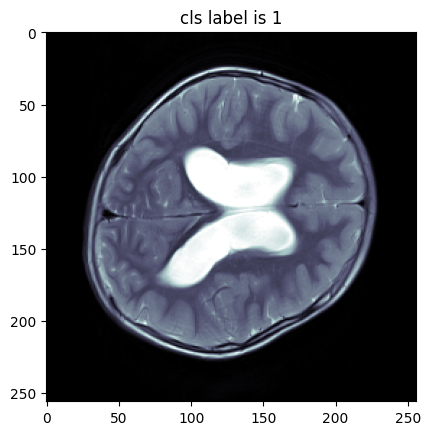

In [1]:
# 分析一下分类图像的样子
import pandas as pd 
import matplotlib.pyplot as plt
from process_data import MriDataset
from torch.utils.data import Dataset, DataLoader
import numpy as np 

data_infos_path = '../all_data_infos_new_class_selected_sequence_5fold.xlsx'
df_data = pd.read_excel(data_infos_path,converters={"检查流水号": str})
test_dataset = MriDataset('../data/', df_data, phase='train')
train_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
for i, batch in enumerate(train_loader):
    ori_image = batch['image'][0, :, :, :, :].numpy()
    cls_image = batch['cls_image'][0, :, :, :].numpy()
    mask_image = batch['mask'][0, :, :, :, :].numpy()
    cls_label = batch['cls'][0].numpy()
    # cls_image = np.transpose(cls_image, (1, 2, 0))
    
    # img_data = batch_data['image'][0, :, :, :, :].numpy() # batch x sequence_num x h x w x slice_num
    # x, y, z = np.nonzero(np.sum(img_data, axis=0) != 0)
    # print(len(z))
    # print(len(y))
    # print(len(x))
    # ymin, xmin, zmin = [max(0, int(np.min(arr) - 1)) for arr in (y, x, z)]
    # ymax, xmax, zmax = [int(np.max(arr) + 1) for arr in (y, x, z)]
    # print(ymin, xmin, zmin)
    # print(ymax, xmax, zmax)
    # patient_image = img_data[:, ymin:ymax, xmin:xmax, zmin:zmax]
    # new_image = patient_image[0, :, :, :]
    # img_data = np.transpose(img_data[0, :, :, :], (2, 0, 1)) # slice_num x h x w
    # print(ori_image.shape)
    # print(cls_image.shape)
    # fig, ax = plt.subplots(1, 1, figsize = (20, 20))
    # ax.imshow(montage(img_data), cmap ='bone')
    #     ax.imshow(np.ma.masked_where(mask == False, mask),
    #             cmap='cool', alpha=0.6)
    print('ori image shape is {}'.format(ori_image.shape))
    print('cls image shape is {}'.format(cls_image.shape))
    print('mask image shape is {}'.format(mask_image.shape))
    plt.imshow(cls_image[:, :, 3], cmap='bone')
    plt.title('cls label is {}'.format(cls_label))
    # plt.imshow(ori_image[2, :, :, 6], cmap='bone')
    # plt.show()
    break

In [ ]:
# 画图，把训练数据展示出来
from skimage.util import montage
from skimage.transform import rotate
nii_path = '../data/new_label_format/'
# plt.figure(figsize=(20, 20))
# fig, axs = plt.subplots(24, 4, figsize=(25, 5))
slices = 24
for s in range(slices):
    plt.figure(figsize=(12,4))
    for i, file in enumerate(os.listdir('../data/example_data/曾彬_nii/')):
        
        plt.subplot(1, 4, i+1)
        example_data = nib.load(nii_path + file).get_fdata()
        # print('file name - {} origin shape is {}'.format(file, example_data.shape))

        t1 = np.rot90(example_data) 

        # t1 = np.transpose(t1,(2,0,1))
        # t1 = example_data
        # print('transpose shape is {}'.format(t1.shape))
        # for s in slices:
        # plt.subplot(24, 4, )
        img_slice = t1[:, :, s]

        # print(img_slice.shape)
        resize_img_slice = cv2.resize(img_slice, (256, 256))
        # cv2.rota
        # resize_img_slice = np.resize(img_slice, (384, 384))
        # print(resize_img_slice.shape)
        # t1 = np.resize(t1, (t1.shape[0], 512, 512))
        # t1 = np.rot90(resize_img_slice) 
        
        # axs[s, i].set_title(file)
        # axs[s, i].imshow(resize_img_slice, cmap='bone')
        plt.imshow(resize_img_slice, cmap='bone')
plt.show()

In [ ]:
from skimage.transform import resize
nii_path = '../data/new_label_format/seg.nii.gz'
example_data = nib.load(nii_path).get_fdata()
print(example_data.shape)
# t = np.transpose(example_data, (2, 0, 1))
# print(example_data.shape)
t = np.rot90(example_data)
t = np.transpose(t, (2, 0, 1))
print(t.shape)
t = resize(t, (24, 256, 256),preserve_range=True)
mask = np.clip(t.astype(np.uint8), 0, 2).astype(np.float32)
mask = np.clip(mask, 0, 2)
# print(t.shape)
print(np.unique(mask))
# fig, ax = plt.subplots(1, 1, figsize = (15, 15))
# ax.imshow(montage(t), cmap ='bone')

# print(t.shape)
# a = np.asarray(t)
# a.shape
# np.unique(t)
# v = np.nonzero(t)
# len(v[0])

In [ ]:
from skimage.transform import resize
nii_path = '../data/new_label_format/'
for file in os.listdir(nii_path):
    data_name = os.path.join(nii_path, file)
    example_data = nib.load(data_name).get_fdata()
    print(example_data.shape)
    # t = np.transpose(example_data, (2, 0, 1))
    # print(example_data.shape)
    t = np.rot90(example_data)
    t = np.transpose(t, (2, 0, 1))
    print(t.shape)
    t = resize(t, (24, 256, 256),preserve_range=True)
    print(t.shape)
    fig, ax = plt.subplots(1, 1, figsize = (15, 15))
    
    ax.imshow(montage(t), cmap ='bone')
# print(t.shape)
# a = np.asarray(t)
# a.shape
# np.unique(t)
# v = np.nonzero(t)
# len(v[0])

In [ ]:
# 测试一下dataloader
from process_data import MriDataset, get_transforms3d
from torch.utils.data import DataLoader
from skimage.util import montage
df_data = pd.read_csv('../data/data_0618_patient_sequence_and_label_name.tsv', sep='\t')
# new_df_data = df_data[df_data['image_name'] != None]
# annotation_data = pd.read_csv('../data/train_annotations.csv')
# train_transf = get_transforms('train')

test_dataset = MriDataset('../data/data_0618', df_data, phase='test')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False,)
for i, batch_data in enumerate(test_loader):
    print(batch_data['image'].size())
    img_data = batch_data['image'][0, :, :, :, :].numpy() # batch x sequence_num x h x w x slice_num
    x, y, z = np.nonzero(np.sum(img_data, axis=0) != 0)
    # print(len(z))
    # print(len(y))
    # print(len(x))
    ymin, xmin, zmin = [max(0, int(np.min(arr) - 1)) for arr in (y, x, z)]
    ymax, xmax, zmax = [int(np.max(arr) + 1) for arr in (y, x, z)]
    # print(ymin, xmin, zmin)
    # print(ymax, xmax, zmax)
    patient_image = img_data[:, ymin:ymax, xmin:xmax, zmin:zmax]
    new_image = patient_image[0, :, :, :]
    img_data = np.transpose(img_data[0, :, :, :], (2, 0, 1)) # slice_num x h x w
    print(img_data.shape)
    # fig, ax = plt.subplots(1, 1, figsize = (20, 20))
    # ax.imshow(montage(img_data), cmap ='bone')
#     ax.imshow(np.ma.masked_where(mask == False, mask),
#             cmap='cool', alpha=0.6)
    plt.imshow(img_data[3, :, :], cmap='bone')
    plt.show()
    break

In [ ]:
# 分析一下原始数据的slice
data_dir = '../data/'
patient_names = os.listdir(data_dir)
patient_names = [x for x in patient_names if x!= '.DS_Store']

for patient_ in patient_names:
    img_names = os.listdir(os.path.join(data_dir, patient_))
    img_names = [x for x in img_names if x!='.DS_Store' and x!='pred.nii.gz']
    for img_ in img_names:
        nii_data = nib.load(os.path.join(data_dir, patient_, img_)).get_fdata()
        print(nii_data.shape)
        print(nii_data.shape[2])
        # if nii_data.shape[2] != 24:
        #     print(nii_data.shape)
        # if nii_data.shape[2] > 100:
        #     print(os.path.join(data_dir, patient_, img_))

all patient num is 193
all classification num is 5


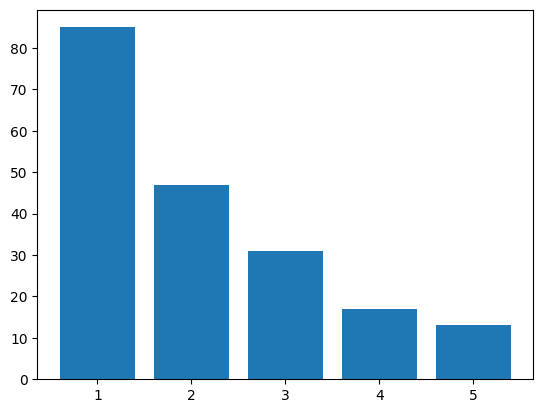

3 31
1 85
2 47
4 17
5 13


In [1]:
# 分析一下分类标签的分布
import pandas as pd 
import matplotlib.pyplot as plt 
from collections import defaultdict
data_infos_path = '../new_all_data_infos_class_v3_5fold_final.xlsx'
df_infos = pd.read_excel(data_infos_path,converters={"检查流水号": str})
# df_infos.rename(columns={"检查流水号": "Id", "姓名": "Name", "性别": "Gender", "年龄": "Age", "组织学分型(经典型=1，促纤维结合增生型=2，大细胞间变型=3，广泛结节型=4，NOS=5)": "Classification", "组织学分型": "Class_Desc"}, inplace=True)
# df_infos.to_excel('../all_data_infos.xlsx', index=False, float_format='%.0f')
# merged_data.to_excel('final_data_infos.xlsx', index=False, float_format='%.0f')
print('all patient num is {}'.format(len(df_infos['Id'].unique())))
print('all classification num is {}'.format(len(df_infos['Classification'].unique())))
class_to_num = defaultdict(int)
for _, row in df_infos.iterrows():
    class_to_num[row['Classification']] += 1
x_label = sorted(list(class_to_num.keys()))
y_label = [class_to_num[x] for x in x_label]
plt.bar(x_label, y_label)
plt.show()
for k, v in class_to_num.items():
    print(k, v)